#  Analysis of `Epicurious.com` recipes

- Data source: https://www.kaggle.com/hugodarwood/epirecipes 

- This is an `open-ended & fun` project where the chief objective is to gain useful insights into a real-life dataset.

## Contents

1. Discover healthy food that fits my macros.
2. Investigate underlying patterns (if any) in all recipes using Unsupervised Learning
3. Predict ratings based on recipes (Supervised learning)
        3.1 Spot Check K-Nearest Neighbor Algorithm
        3.2 Understanding meaning of "Accuracy" in mutli-class classification
        3.3 Use Principal Component Analysis for Dimension Reduction
        3.4 Use Random Forest Classifier
        3.5 Use PCA+Random Forest+Cross-validation
        3.6 Use Grid Search to optimize RandomForest
        3.7 Generate Multi-class (ROC) and AUC to quantify quality of results


In [53]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

pd.set_option("display.max_rows", None)



In [54]:
#Importing the dataset
dataset = pd.read_csv('./epicurious-recipes-with-rating-and-nutrition/epi_r.csv')

In [55]:
# head
display(dataset.head(3))

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#Remove NAs
dataset=dataset.dropna()

## 1. Discover healthy food that fits my macros

After putting some holiday weight, I want to get into a low-carb diet and would like to check recipes that 
fit my macros

![Image](http://1.bp.blogspot.com/-a12bv9KmJF4/VQ8yaYcPW_I/AAAAAAAAOIg/r4Ukly7jp7U/s1600/0.1.jpg)

In [57]:
#Subsetting title','rating','calories','protein','fat' columns
recipes_with_macros=dataset[['title','rating','calories','protein','fat']];
recipes_with_macros.is_copy = False

#Adding carbohydate column. Calculate carbohydate in grams by using the following
#formula Carbs(in gm)=[Calories-9*fat(in gm)-4*protein(in gm)]/4 
#Note Caloriesin 1 gm of carb=4,Protein=4 & Fat=9
recipes_with_macros.loc[:,'carbs']=recipes_with_macros.apply(lambda row: \
                   round((row['calories']-9*row['fat']-4*row['protein'])/4), axis=1)

#Remove negative carbs
recipes_with_macros=recipes_with_macros.loc[(recipes_with_macros['carbs'] > 0)]

#Adding percentagesof calories for protein,fat & carbs.
recipes_with_macros.at[:,'%protein']=recipes_with_macros.apply(lambda row: row['protein']*400/row['calories'], axis=1)
recipes_with_macros.at[:,'%fat']=recipes_with_macros.apply(lambda row: row['fat']*900/row['calories'], axis=1)
recipes_with_macros.at[:,'%carbs']=recipes_with_macros.apply(lambda row: row['carbs']*400/row['calories'], axis=1)

display(recipes_with_macros.head(3))

,title,rating,calories,protein,fat,carbs,%protein,%fat,%carbs
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,61,28.169014,14.788732,57.276995
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,31,17.866005,51.364764,30.769231
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,20,14.545455,38.181818,48.484848


In [58]:
CARBS_RANGE=[10,30]
PROTEIN_RANGE=[40,50]
FAT_RANGE=[30,40]

healthy_recipes=recipes_with_macros[(recipes_with_macros['%carbs'] >CARBS_RANGE[0]) & \
                                    (recipes_with_macros['%carbs'] <CARBS_RANGE[1]) & \
                                    (recipes_with_macros['%protein'] >PROTEIN_RANGE[0]) & \
                                    (recipes_with_macros['%protein'] <PROTEIN_RANGE[1]) & \
                                    (recipes_with_macros['%fat'] >FAT_RANGE[0]) & \
                                    (recipes_with_macros['%fat'] <FAT_RANGE[1])]

#Display by lowest calories,highest rating
healthy_recipes=healthy_recipes.sort_values(['calories', 'rating'], ascending=[True, False])
display(healthy_recipes)

,title,rating,calories,protein,fat,carbs,%protein,%fat,%carbs
12343,Spiced Shrimp,4.375,26.0,3.0,1.0,1,46.153846,34.615385,15.384615
19770,Poached Chicked with Curried Yogurt Sauce,3.125,106.0,11.0,4.0,6,41.509434,33.962264,22.641509
471,Cheese- and Shrimp-Stuffed Roasted Poblanos wi...,4.375,116.0,12.0,5.0,6,41.379310,38.793103,20.689655
10398,Cheese- and Shrimp-Stuffed Roasted Poblanos wi...,4.375,116.0,12.0,5.0,6,41.379310,38.793103,20.689655
1667,Fiery Grilled Shrimp with Honeydew Gazpacho,4.375,144.0,17.0,5.0,8,47.222222,31.250000,22.222222
13853,Turkey Salad,3.750,147.0,18.0,6.0,5,48.979592,36.734694,13.605442
12196,Grilled Shrimp and Scallions with Southeast As...,4.375,155.0,18.0,6.0,7,46.451613,34.838710,18.064516
19082,Chipotle-Glazed Shrimp,3.750,156.0,16.0,6.0,10,41.025641,34.615385,25.641026
5330,Shortcut Turkey Stock,5.000,162.0,18.0,6.0,9,44.444444,33.333333,22.222222
13749,Shortcut Turkey Stock,5.000,162.0,18.0,6.0,9,44.444444,33.333333,22.222222


#### `Observations: Only 123 our of 20k recipes are "healthy". Quite a few shrimp & turkey recipes on top !`

In [59]:
#<TBD insert word coud>

## 2. Investigate underlying patterns (if any) in all recipes using Unsupervised Learning

An unsupervized k-means was peformed on all food recipes.

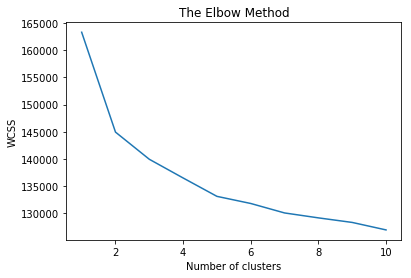

In [60]:
X_KNN = dataset.iloc[:, 6:680].values

# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_KNN)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_KNN)

In [61]:
#Subsetting 'title'
recipes=dataset[['title']];
recipes.is_copy = False
recipes.at[:,'Cluster']=y_kmeans
display(recipes[recipes['Cluster']==2].head(20))

,title,Cluster
12,Banana-Chocolate Chip Cake With Peanut Butter ...,2
16,Sweet Buttermilk Spoon Breads,2
29,Apricot-Cherry Shortcakes,2
40,Coconut-Key Lime Sheet Cake,2
57,Pumpkin Muffins,2
64,Mixed Berry Pavlovas,2
68,White Chocolate Tartlets with Strawberries and...,2
72,Pear-Hazelnut Cheesecakes with Pear-Raspberry ...,2
75,Banana Layer Cake with Cream Cheese Frosting,2
104,Stout Floats,2


#### `Observation: Desserts is a special cateogory according to K-means`

In [62]:
#It was difficult to assess the physical interpretations of clusters 1 and 2
display(recipes[recipes['Cluster']==0].head(5))
display(recipes[recipes['Cluster']==1].head(5))

,title,Cluster
0,"Lentil, Apple, and Turkey Wrap",0
1,Boudin Blanc Terrine with Red Onion Confit,0
2,Potato and Fennel Soup Hodge,0
4,Spinach Noodle Casserole,0
5,The Best Blts,0


,title,Cluster
9,Ham Persillade with Mustard Potato Salad and M...,1
19,"Tuna, Asparagus, and New Potato Salad with Chi...",1
26,Cucumber-Basil Egg Salad,1
28,"Green Bean, Red Onion, and Roast Potato Salad ...",1
32,Roasted Sweet-Potato Spears with Bacon Vinaigr...,1


## 3. Predict ratings based on recipes (Supervised learning)

In [63]:
X = dataset.iloc[:, 2:680].values
y = dataset.iloc[:, 1].values

# Encode th output
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [64]:
df=pd.DataFrame({'Rating':np.unique(recipes_with_macros['rating']),'Count':dataset.groupby(encoded_y).size()})
display(df)

,Count,Rating
0,1296,0.000
1,123,1.250
2,81,1.875
3,405,2.500
4,1165,3.125
5,4136,3.750
6,6552,4.375
7,2106,5.000


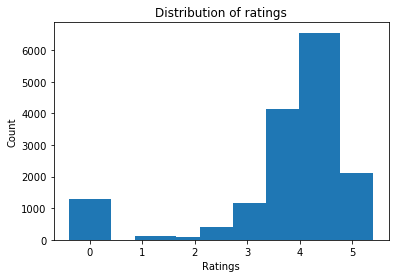

In [65]:
plt.figure()
plt.bar(df['Rating'],df['Count'])
plt.title('Distribution of ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

#### `Observation: There are 8 kinds ratings. We have a multi-class classification problem`

Multi-class classification are "exponentially" more complex. 
I could have reduced the problem to a easier binary classification but where is the fun in that :)

### 3.1 Spot Check K-Nearest Neighbor Algorithm

In [66]:
###########Try out a few algorithms###########################################
##############################################################################
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2,n_jobs=-1)
classifier_KNN.fit(X_train, y_train)

# Predicting the Test set results
y_pred_KNN = classifier_KNN.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_KNN = confusion_matrix(y_true=y_test, y_pred=y_pred_KNN)

In [67]:
print ("Accuracy KNN=",cm_KNN.trace()/cm_KNN.sum())

Accuracy KNN= 0.35930408472


In [68]:
display("Confusion Matrix",cm_KNN)

'Confusion Matrix'

array([[137,   3,   0,   3,   9,  45,  67,  51],
       [  7,   1,   0,   2,   0,   8,  12,   3],
       [  3,   1,   1,   0,   1,   6,   5,   0],
       [ 16,   2,   0,   3,   8,  30,  40,   6],
       [ 32,   2,   0,   9,  20,  87, 113,  13],
       [100,   4,   4,  19,  64, 372, 423,  39],
       [142,   6,   5,  15,  98, 475, 822, 108],
       [ 88,   3,   2,   6,  32, 128, 196,  69]])

### 3.2 Understanding meaning of "Accuracy" in mutli-class classification 

The accuracy seems bad but we should be aware that this is not a binary classifier and all the ratings are not uniformly distributed.

It is important to have a dumb/naive predictor so that we have an idea whether
our classification methods are of any improvemnt.

How to design a `naive` predictor ? 

I suggest that we roll a dice according the distribution of class-labels (see histogram above) and estimate accuracy
with standard deviation. 


In [69]:
################################################################################
#Create a fake/naive  confusion matrix##########################################
p1=(dataset.groupby(encoded_y).size()).values
p1= list(p1/float(p1.sum()))
y_sample=[]
for sample in range(0,30):
    y_fake=[]
    for i,j in enumerate(y_test):
        y_fake.append(np.random.choice(np.arange(0, 8), p=p1))
    
    cm_FAKE = confusion_matrix(y_test, y_fake)
    y_sample.append(cm_FAKE.trace()/float(cm_FAKE.sum()))

print ("Average Accuracy naive/fake model=",np.asarray(y_sample).mean(),"std=",np.asarray(y_sample).std())
################################################################################

Average Accuracy naive/fake model= 0.272482770213 std= 0.0070927528001


#### `Observation : KNN does improve classification rate; it is still not as ideal`

### 3.3 Use Principal Component Analysis for Dimension Reduction

In [70]:
## Let's try some dimension reduction techniques
########################Dimesnion Reduction###################################

# Applying PCA
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

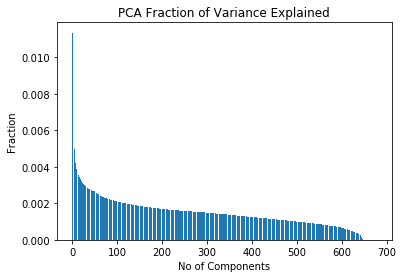

In [71]:
plt.figure()
plt.bar(range(0,len(explained_variance)),explained_variance)
plt.title('PCA Fraction of Variance Explained')
plt.xlabel('No of Components')
plt.ylabel('Fraction')
plt.show()

Very low percentage of variance is explained by the initial principal components.

### 3.4 Use Random Forest Classifier 
which typically has good "out-of-box" performance

In [72]:
##############################################################################
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier_RFC = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0,n_jobs=-1)
classifier_RFC.fit(X_train, y_train)

# Predicting the Test set results
y_pred_RFC = classifier_RFC.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_RFC = confusion_matrix(y_test, y_pred_RFC)
print ("Accuracy RFC=",cm_RFC.trace()/cm_RFC.sum())

Accuracy RFC= 0.513363590519


#### `Obsevation: Substantial improvement over KNN`

We should try dimension reduction techniques and see if it helps.
Also we shall introduce `cross-validation` to quantify mean accuracy & standard-deviation

### 3.5 Use PCA+Random Forest+Cross-validation

In [73]:
y_accuracy=[]
# Applying PCA
for i in range(1,678,10):
    pca = PCA(n_components = i)
    X_train1 = pca.fit_transform(X_train)
    X_test1 = pca.transform(X_test)
    
    classifier_RFC = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0, n_jobs =-1)
    classifier_RFC.fit(X_train1, y_train)
    
    # Predicting the Test set results
    y_pred_RFC = classifier_RFC.predict(X_test1)
    
    # Making the Confusion Matrix
    cm_RFC = confusion_matrix(y_test, y_pred_RFC)
    y_accuracy.append(cm_RFC.trace()/float(cm_RFC.sum()))

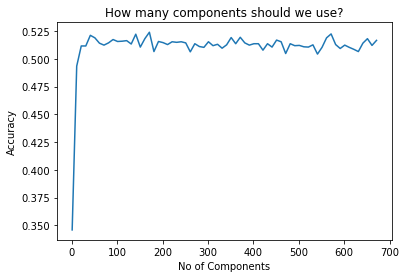

In [74]:
plt.figure()
plt.plot(range(1,678,10),y_accuracy)
plt.title('How many components should we use?')
plt.xlabel('No of Components')
plt.ylabel('Accuracy')
plt.show()

In [27]:
    pca = PCA(n_components = 100)
    X_train1 = pca.fit_transform(X_train)
    X_test1 = pca.transform(X_test)
    
    classifier_RFC = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0, n_jobs =-1)
    classifier_RFC.fit(X_train1, y_train)
    
    # Predicting the Test set results
    y_pred_RFC = classifier_RFC.predict(X_test1)
    
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier_RFC, X = X_train1, y = y_train, cv = 10)
    print ("Average Accuracy Random Forest+PCA=",accuracies.mean(),"std=", accuracies.std())

Average Accuracy Random Forest+PCA= 0.500757505019 std= 0.0085357213104


### 3.6 Use Grid Search to optimize RandomForest

In [29]:
from sklearn.model_selection import GridSearchCV

# use a full grid over all parameters
param_grid = {"max_features": range(100,200,10),           
              "criterion": ["entropy","gini"]}

# run grid search
grid_search = GridSearchCV(classifier_RFC, param_grid=param_grid,cv=10,n_jobs=-1,scoring = 'accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(100, 200, 10), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [30]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [31]:
print (best_accuracy)

0.503614052782


In [32]:
print (best_parameters)

{'criterion': 'entropy', 'max_features': 190}


#### `Observation: Demonstration of Grid Search`
The above Grid Search was for demonstration purpose only.
I need to exhaustively on more parameters of Random Forest
(which was paused due to run-time considerations)

### 3.7 Generate Multi-class (ROC) and AUC to quantify quality of results
- ROC is valid for binary classification
- We transform multi-class classification to binary classification using OnevsAll method

- Source: https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest
- Code source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- Algorithm: https://software.intel.com/en-us/daal-programming-guide-quality-metrics-for-multi-class-classification-algorithms

In [34]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y = label_binarize(encoded_y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
n_classes = y.shape[1]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting OVRC-Random Forest to the Training set
from sklearn.multiclass import OneVsRestClassifier
classifier_OVRC = OneVsRestClassifier(RandomForestClassifier(n_estimators = 130, criterion = 'gini', random_state = 0),n_jobs=-1)
classifier_OVRC.fit(X_train, y_train)

# Predicting the Test set results
y_pred_OVRC = classifier_OVRC.predict(X_test)

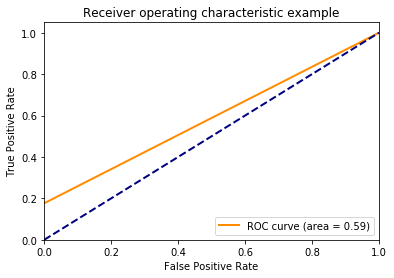

In [35]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_OVRC[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_OVRC.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

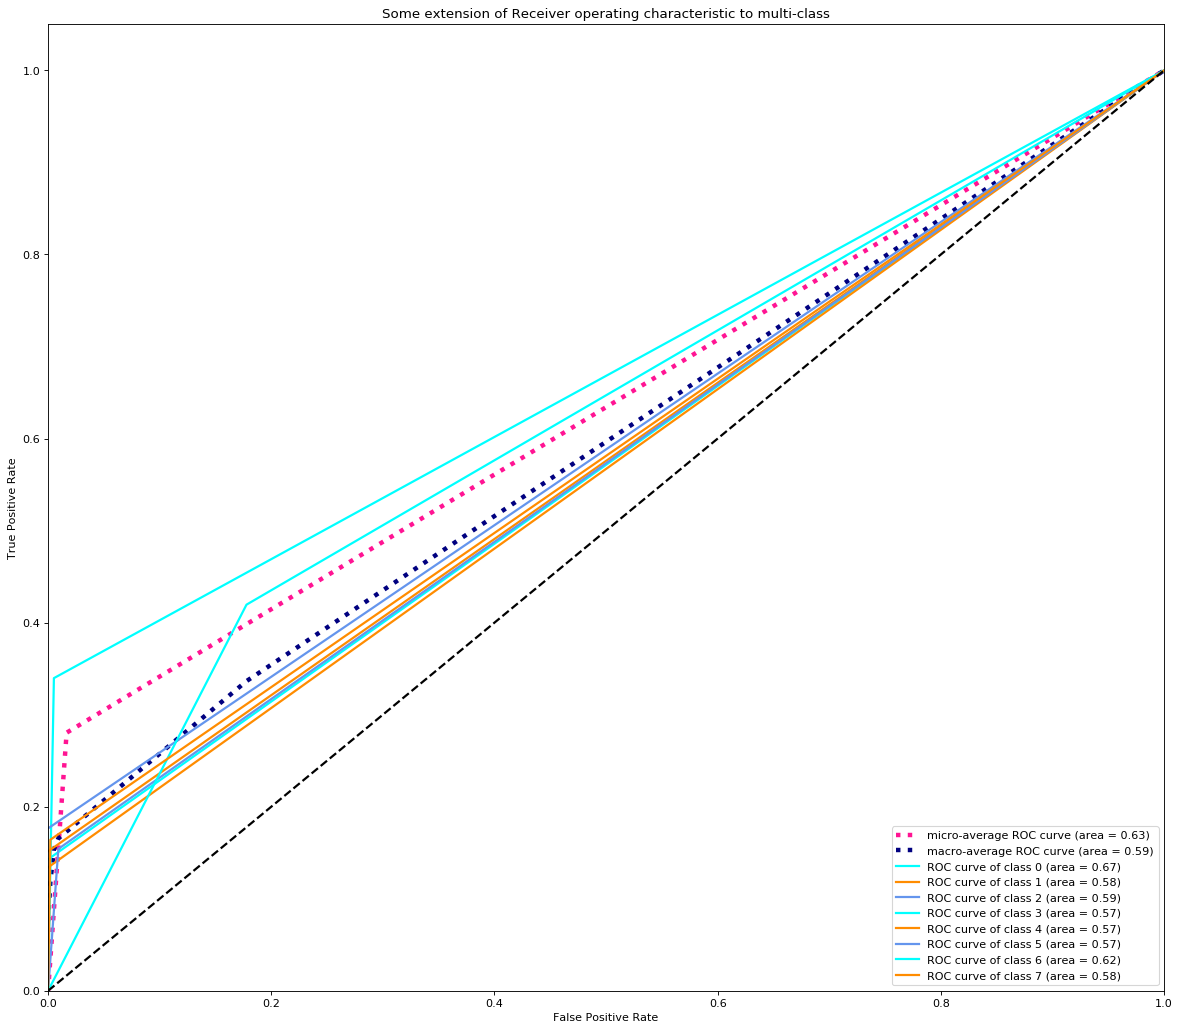

In [42]:
from scipy import interp
from itertools import cycle


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Next Steps...
The next thing I would include is feature selection. 
For example zero star rating means it has not been rated yet.
Length of recipes should have been a feature and so so on.